<a href="https://colab.research.google.com/github/Azimoj/Home-Credit-Default-Risk/blob/main/Dash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [45]:
# Chargement des librairies
import datetime
import sys
import time
from datetime import datetime
import warnings
import jyquickhelper
import numpy as np
import pandas as pd
import pickle
from joblib import dump, load
from collections import Counter


# Visualisation
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import plotly.graph_objects as go


In [ ]:
! pip install jyquickhelper

In [46]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [47]:
dico_pd_option = {
    'display.max_rows': 500,
    'display.max_column': 200,
    'display.width': 300,
    'display.precision': 4,
    'display.max_colwidth': 1000,
    'mode.chained_assignment': None
}
for cle, val in dico_pd_option.items():
    pd.set_option(cle, val)

In [74]:
application_train = pd.read_csv('/content/drive/MyDrive/p7/data/application_train.csv')
application_train.shape

(307511, 122)

In [75]:
# Correction valeurs aberrantes
application_train['DAYS_EMPLOYED'][application_train['DAYS_EMPLOYED']
                                   == 365243] = 0

In [76]:
# Correction : difficile d'imputer le sexe par le mode de cette catégorie
# Comme il n'y a que 4 clients avec un sexe non renseigné, on supprime ces
# valeurs
application_train = \
    application_train[application_train['CODE_GENDER'] != 'XNA']
application_train.shape

(307507, 122)

In [77]:
application_test = pd.read_csv('/content/drive/MyDrive/p7/data/application_test.csv')
application_test.shape

(48744, 121)

In [78]:
# Correction valeurs aberrantes
application_test['DAYS_EMPLOYED'][application_test['DAYS_EMPLOYED']
                                  == 365243] = 0

In [80]:
data = application_train.append(application_test).reset_index()

In [83]:
data = data[data['TARGET'].notnull()]

In [85]:
from sklearn.model_selection import train_test_split
app_train, app_test = train_test_split(data ,test_size = 0.3,random_state=0)
print('The shape of app_train is', app_train.shape)
print('The shape of app_test is', app_test.shape)

The shape of app_train is (215254, 123)
The shape of app_test is (92253, 123)


In [53]:
train_set = pd.read_csv('/content/drive/MyDrive/p7/data/X_train_final.csv')
train_set.shape

(215253, 85)

In [54]:
test_set = pd.read_csv('/content/drive/MyDrive/p7/data/X_test_final.csv')
test_set.shape

(92252, 85)

In [30]:
test_set.keys()

Index(['SK_ID_CURR', 'CODE_GENDER', 'FLAG_OWN_CAR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_AVG', 'YEARS_BEGINEXPLUATATION_MODE', 'TOTALAREA_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_6', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'HOUR_APPR_PROCESS_START_SIN', 'NEW_DAYS_EMPLOYED_PERC', 'NEW_INCOME_CREDIT_PERC', 'NEW_INCOME_PER_PERSON', 'NEW_ANNUITY_INCOME_PERC',
       'NEW_ANNUITY_CREDIT_RATIO', 'NEW_EXT_MEAN', 'NEW_AGE', 'NEW_DEF_30&60_SOCIAL_CIRCLE', 'NAME_CONTRACT_TYPE_Cash loans', 'NAME_CONTRACT_TYPE_Revolving lo

In [55]:
# Copie du jeu de test
test = test_set.copy(deep=True)
# Sauvegarde des identifiants des clients inutiles aux prédictions
id_client = test['SK_ID_CURR']
# Préparation de la matrice à soumettre aux prédictions 
X_test = test.drop('SK_ID_CURR', axis=1)

In [56]:
import pickle
filename = 'drive/MyDrive/p7/model.sav'
best_model= pickle.load(open(filename, 'rb'))

In [57]:
# Score des prédictions de probabiltés
y_proba = best_model.predict_proba(X_test)[:, 1]

In [58]:
# Prédictions pour le client :
# classe 0 : non défaillant, classe 1 : défaillant
y_pred = best_model.predict(X_test)

In [59]:
# Constitution du dataframe pour merge
df_score = pd.DataFrame({'SK_ID_CURR' : id_client,
                         'PRED_CLASSE_CLIENT' : y_pred,
                         'SCORE_CLIENT' : y_proba,
                         'SCORE_CLIENT_%' : np.round(y_proba * 100, 1)})
df_score.head(3)

,SK_ID_CURR,PRED_CLASSE_CLIENT,SCORE_CLIENT,SCORE_CLIENT_%
0,434953,0.0,0.3691,36.9
1,318538,0.0,0.4272,42.7
2,309973,1.0,0.5646,56.5


In [60]:
df_score.shape

(92252, 4)

In [61]:
# Ajout des prédictions au dataframe du jeu de test
df_dashboard = df_score.merge(test_set, on='SK_ID_CURR', how='left')
df_dashboard.head(3)

,SK_ID_CURR,PRED_CLASSE_CLIENT,SCORE_CLIENT,SCORE_CLIENT_%,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,AMT_REQ_CREDIT_BUREAU_YEAR,HOUR_APPR_PROCESS_START_SIN,NEW_DAYS_EMPLOYED_PERC,NEW_INCOME_CREDIT_PERC,NEW_INCOME_PER_PERSON,NEW_ANNUITY_INCOME_PERC,NEW_ANNUITY_CREDIT_RATIO,NEW_EXT_MEAN,NEW_AGE,NEW_DEF_30&60_SOCIAL_CIRCLE,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_nan,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_nan,HOUSETYPE_MODE_house_type_reported,HOUSETYPE_MODE_nan,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_nan,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_nan,NEW_REVOLVING_LOANS_0.0,NEW_REVOLVING_LOANS_1.0,NEW_HAS_CAR_0.0,NEW_HAS_CAR_1.0,NEW_HAS_COMPANY_0.0,NEW_HAS_COMPANY_1.0,NEW_LABORERS_0.0,NEW_LABORERS_1.0,NEW_AGE_SEGMENT_MİDDLE,NEW_AGE_SEGMENT_OLD,NEW_AGE_SEGMENT_YOUNG
0,434953,0.0,0.3691,36.9,0,1,0,135000.0,654498.0,31486.5,0.0186,-19240,-3441.0,-1734.0,-2790,0,0,2,2,0,0,0,0.4464,0.6956,0.9816,0.1667,0.9816,0.0688,0.0,0.0,0.0,-1888.0,1,0,3.0,-0.8879,0.1788,0.2063,67500.0,0.2332,0.0481,0.5710,52.7123,0.0,1,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,1,0,0,1,1,0,1,0,1,0,0
1,318538,0.0,0.4272,42.7,1,1,1,135000.0,270000.0,13500.0,0.0202,-15653,-1026.0,-3103.0,-4392,0,1,3,3,0,0,0,0.2936,0.6691,0.9816,0.1667,0.9816,0.0688,1.0,0.0,0.0,-474.0,0,0,0.0,-0.6311,0.0655,0.5000,45000.0,0.1000,0.0500,0.5239,42.8849,0.0,0,1,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0,0
2,309973,1.0,0.5646,56.5,0,0,1,94500.0,180000.0,9000.0,0.0252,-8206,-781.0,-3051.0,-877,1,1,2,2,0,1,1,0.5247,0.3690,0.9816,0.1667,0.9816,0.0688,0.0,0.0,0.0,-362.0,0,0,2.0,0.3984,0.0952,0.5250,31500.0,0.0952,0.0500,0.4468,22.4822,0.0,0,1,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,0,1,0,0,1,0,0,1


In [62]:
# Sauvegarde de df_dashboard
fic_sav_df_dashboard ='drive/MyDrive/p7/df_dashboard_1.pickle'
with open(fic_sav_df_dashboard, 'wb') as f:
    pickle.dump(df_dashboard, f, pickle.HIGHEST_PROTOCOL)

In [68]:
# Chargement du dataframe df_dashboard_1
fic_sav_df_dashboard_1 ='drive/MyDrive/p7/df_dashboard_1.pickle'
with open(fic_sav_df_dashboard_1, 'rb') as df_dashboard_1:
    df_dashboard = pickle.load(df_dashboard_1)
df_dashboard.shape

(92252, 88)

In [69]:
df_dashboard.isnull().sum().sort_values(ascending=False).head(5)

SK_ID_CURR                            0
PRED_CLASSE_CLIENT                    0
OCCUPATION_TYPE_Sales staff           0
OCCUPATION_TYPE_Managers              0
OCCUPATION_TYPE_Low-skill Laborers    0
dtype: int64

Les données informatives sur le client à rendre disponible et lisible pour le chargé de clientèle :

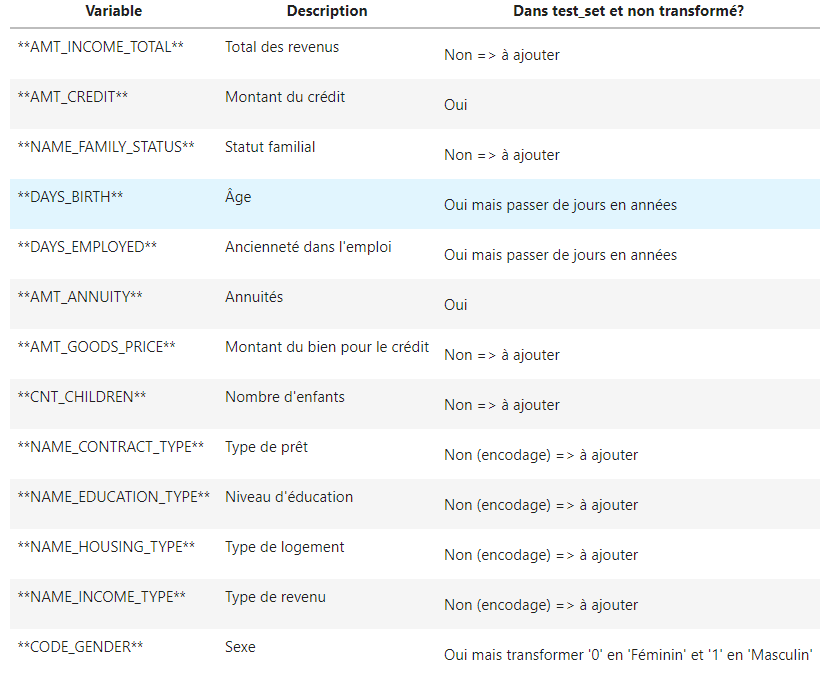

In [71]:
df_infos =application_test[['SK_ID_CURR',
                            'AMT_INCOME_TOTAL', 'NAME_FAMILY_STATUS',
                            'AMT_GOODS_PRICE', 'CNT_CHILDREN',
                            'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE',
                            'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE']]
df_infos.head(3)

,SK_ID_CURR,AMT_INCOME_TOTAL,NAME_FAMILY_STATUS,AMT_GOODS_PRICE,CNT_CHILDREN,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,NAME_INCOME_TYPE
0,100001,135000.0,Married,450000.0,0,Cash loans,Higher education,House / apartment,Working
1,100005,99000.0,Married,180000.0,0,Cash loans,Secondary / secondary special,House / apartment,Working
2,100013,202500.0,Married,630000.0,0,Cash loans,Higher education,House / apartment,Working


In [72]:
df_infos.shape

(48744, 9)

In [66]:
# Ajout des varaibles manquantes au dataframe du dashboard
df_dashboard = df_dashboard.merge(df_infos, on='SK_ID_CURR', how='right')
df_dashboard.head(3)

,SK_ID_CURR,PRED_CLASSE_CLIENT,SCORE_CLIENT,SCORE_CLIENT_%,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN_x,AMT_INCOME_TOTAL_x,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,AMT_REQ_CREDIT_BUREAU_YEAR,HOUR_APPR_PROCESS_START_SIN,NEW_DAYS_EMPLOYED_PERC,NEW_INCOME_CREDIT_PERC,NEW_INCOME_PER_PERSON,NEW_ANNUITY_INCOME_PERC,NEW_ANNUITY_CREDIT_RATIO,NEW_EXT_MEAN,NEW_AGE,NEW_DEF_30&60_SOCIAL_CIRCLE,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_nan,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_nan,HOUSETYPE_MODE_house_type_reported,HOUSETYPE_MODE_nan,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_nan,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_nan,NEW_REVOLVING_LOANS_0.0,NEW_REVOLVING_LOANS_1.0,NEW_HAS_CAR_0.0,NEW_HAS_CAR_1.0,NEW_HAS_COMPANY_0.0,NEW_HAS_COMPANY_1.0,NEW_LABORERS_0.0,NEW_LABORERS_1.0,NEW_AGE_SEGMENT_MİDDLE,NEW_AGE_SEGMENT_OLD,NEW_AGE_SEGMENT_YOUNG,AMT_INCOME_TOTAL_y,NAME_FAMILY_STATUS,AMT_GOODS_PRICE,CNT_CHILDREN_y,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,NAME_INCOME_TYPE
0,100001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,135000.0,Married,450000.0,0,Cash loans,Higher education,House / apartment,Working
1,100005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99000.0,Married,180000.0,0,Cash loans,Secondary / secondary special,House / apartment,Working
2,100013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,202500.0,Married,630000.0,0,Cash loans,Higher education,House / apartment,Working


In [ ]:
import pickle
filename = 'drive/MyDrive/p7/model.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
!pip install -q jupyter-dash==0.3.0rc1 dash-bootstrap-components transformers

     |████████████████████████████████| 45 kB 1.9 MB/s 
     |████████████████████████████████| 209 kB 9.1 MB/s 
     |████████████████████████████████| 3.8 MB 61.7 MB/s 
     |████████████████████████████████| 8.5 MB 44.5 MB/s 
     |████████████████████████████████| 596 kB 49.9 MB/s 
     |████████████████████████████████| 6.5 MB 53.9 MB/s 
     |████████████████████████████████| 67 kB 5.5 MB/s 
     |████████████████████████████████| 895 kB 39.1 MB/s 
     |████████████████████████████████| 357 kB 63.2 MB/s 


In [ ]:
import time

import dash
import dash_html_components as html
import dash_core_components as dcc
import dash_bootstrap_components as dbc
from dash.dependencies import Input, Output, State
from jupyter_dash import JupyterDash
from transformers import AutoModelWithLMHead, AutoTokenizer
import torch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  """


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

print("Start loading model...")
name = "microsoft/DialoGPT-large"
tokenizer = AutoTokenizer.from_pretrained(name)
model = AutoModelWithLMHead.from_pretrained(name)

# Switch to cuda, eval mode, and FP16 for faster inference
if device == "cuda":
    model = model.half()
model.to(device)
model.eval()

print("Done.")

Device: cpu
Start loading model...


Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/642 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:882: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Done.


In [ ]:
def textbox(text, box="other"):
    style = {
        "max-width": "55%",
        "width": "max-content",
        "padding": "10px 15px",
        "border-radius": "25px",
    }

    if box == "self":
        style["margin-left"] = "auto"
        style["margin-right"] = 0

        color = "primary"
        inverse = True

    elif box == "other":
        style["margin-left"] = 0
        style["margin-right"] = "auto"

        color = "light"
        inverse = False

    else:
        raise ValueError("Incorrect option for `box`.")

    return dbc.Card(text, style=style, body=True, color=color, inverse=inverse)

In [ ]:
conversation = html.Div(
    style={
        "width": "80%",
        "max-width": "800px",
        "height": "70vh",
        "margin": "auto",
        "overflow-y": "auto",
    },
    id="display-conversation",
)

controls = dbc.InputGroup(
    style={"width": "80%", "max-width": "800px", "margin": "auto"},
    children=[
        dbc.Input(id="user-input", placeholder="Write to the chatbot...", type="text"),
        dbc.InputGroupAddon(dbc.Button("Submit", id="submit"), addon_type="append",),
    ],
)


# Define app
app = JupyterDash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])
server = app.server


# Define Layout
app.layout = dbc.Container(
    fluid=True,
    children=[
        html.H1("Dash Chatbot (with DialoGPT)"),
        html.Hr(),
        dcc.Store(id="store-conversation", data=""),
        conversation,
        controls,
    ],
)

AttributeError: ignored

In [ ]:
@app.callback(
    Output("display-conversation", "children"), [Input("store-conversation", "data")]
)
def update_display(chat_history):
    return [
        textbox(x, box="self") if i % 2 == 0 else textbox(x, box="other")
        for i, x in enumerate(chat_history.split(tokenizer.eos_token)[:-1])
    ]


@app.callback(
    [Output("store-conversation", "data"), Output("user-input", "value")],
    [Input("submit", "n_clicks"), Input("user-input", "n_submit")],
    [State("user-input", "value"), State("store-conversation", "data")],
)
def run_chatbot(n_clicks, n_submit, user_input, chat_history):
    if n_clicks == 0:
        return "", ""

    if user_input is None or user_input == "":
        return chat_history, ""

    # # temporary
    # return chat_history + user_input + "<|endoftext|>" + user_input + "<|endoftext|>", ""

    # encode the new user input, add the eos_token and return a tensor in Pytorch
    bot_input_ids = tokenizer.encode(
        chat_history + user_input + tokenizer.eos_token, return_tensors="pt"
    ).to(device)

    # generated a response while limiting the total chat history to 1000 tokens,
    chat_history_ids = model.generate(
        bot_input_ids, max_length=1024, pad_token_id=tokenizer.eos_token_id
    )
    chat_history = tokenizer.decode(chat_history_ids[0])

    return chat_history, ""

NameError: ignored

In [ ]:
app.run_server(mode='external')